## Run RouskinHF

In [1]:
from rouskinhf import convert

data = convert(
    'ct',
    '/Users/yvesmartin/data/archiveII',
    name='archiveII',
    path_out='data',
    filter=True
)

Parsing ct files: 100%|██████████| 3975/3975 [00:01<00:00, 2926.37it/s]


Over a total of 3975 datapoints, there are:
### OUTPUT
- ALL: 3486 valid datapoints
- INCLUDED: 26 duplicate sequences with different structure / dms / shape
### MODIFIED
- 1537 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 489 duplicate sequences with the same structure / dms / shape


## Visualise



<Axes: >

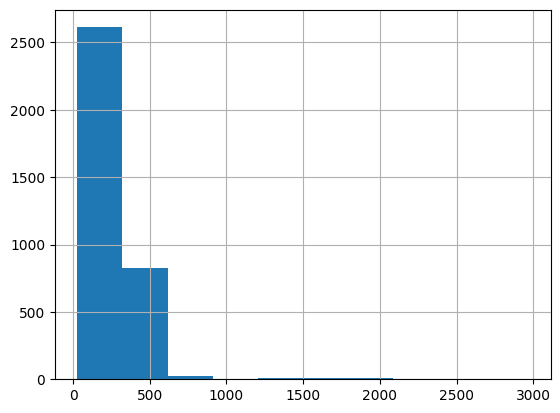

In [2]:
import pandas as pd

df = pd.read_json('data/archiveII/data.json', orient='index')
df.sequence.apply(len).hist(bins=10)

## Upload

In [3]:
from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    'data/archiveII/data.json',
    commit_message='fixed rouskinhf reference bug',
)

In [5]:
import rouskinhf
df_archiveII = pd.DataFrame.from_dict(data, orient='index')
efold_train = rouskinhf.get_dataset('efold_train')
df_efold = pd.DataFrame.from_dict(efold_train, orient='index')


efold_train: Downloading dataset from HuggingFace Hub...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

efold_train: Download complete. File saved at data/efold_train/data.json


In [11]:
def df_to_fastas(df, path_out):
    with open(path_out, 'w') as f:
        for idx, row in df.iterrows():
            f.write('>{}\n{}\n'.format(idx, row['sequence']))

df_to_fastas(df_archiveII, 'data/archiveII/archiveII.fasta')
df_to_fastas(df_efold, 'data/efold_train/efold_train.fasta')

print(len(df_archiveII))

3486


In [12]:
!makeblastdb -in data/efold_train/efold_train.fasta -dbtype nucl -out data/efold_train



Building a new DB, current time: 05/09/2024 14:49:28
New DB name:   /Users/yvesmartin/src/supermodels-data/archiveII/data/efold_train
New DB title:  data/efold_train/efold_train.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 339247 sequences in 3.18507 seconds.




In [15]:
!blastn -query data/archiveII/archiveII.fasta -db data/efold_train -out data/efold_train/efold_train_vs_archiveII.blast -outfmt 6

In [18]:
import pandas as pd

df_blast = pd.read_csv('data/efold_train/efold_train_vs_archiveII.blast', sep='\t', header=None)
df_blast.columns = ['query', 'subject', 'identity', 'length', 'mismatches', 'gaps', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_blast.sort_values('evalue', inplace=True, ascending=True)
df_blast.drop_duplicates('query', keep='first', inplace=True)
df_blast.to_csv('efold_train_vs_archiveII.csv', sep='\t', index=False)

In [24]:
df_blast

,query,subject,identity,length,mismatches,gaps,qstart,qend,sstart,send,evalue,bitscore
721,tmRNA_Prop_3,bpRNA_tmRNA_434,100.0,371,0,0,1,371,1,371,0.0,686.0
502,srp_Kluy,bpRNA_SRP_398,98.317,416,2,2,1,416,1,411,0.0,725.0
503,RNaseP_S_24,bpRNA_RNP_360,100.0,389,0,0,1,389,1,389,0.0,719.0
504,RNaseP_ESH212C,bpRNA_RNP_153,100.0,355,0,0,1,355,1,355,0.0,656.0
505,tmRNA_Stap,bpRNA_tmRNA_550,100.0,361,0,0,1,361,1,361,0.0,667.0
...,...,...,...,...,...,...,...,...,...,...,...,...
925,RNaseP_Prochlorococcus-TATL2-2,bpRNA_RNP_259,100.0,311,0,0,1,311,1,311,9.91e-164,575.0
3435,srp_Cory,bpRNA_SRP_226,100.0,52,0,0,1,52,1,52,9.950000000000001e-21,97.1
3434,srp_Cory_5,bpRNA_SRP_227,100.0,52,0,0,1,52,1,52,9.950000000000001e-21,97.1
2763,5s_Bacteroides-fragilis-2,RF02271.fa.csv_6262,96.296,108,4,0,3,110,3,110,9.959999999999999e-45,178.0


Text(0, 0.5, 'Identity (%)')

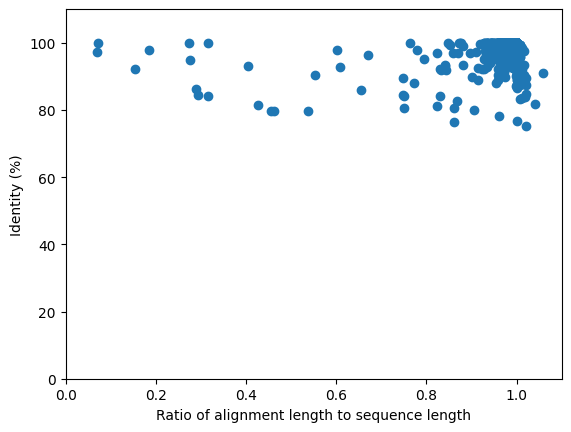

In [33]:
df = pd.merge(df_blast, pd.DataFrame.from_dict(data, orient='index'), left_on='query', right_index=True, how='inner')
df['ratio'] = df['length'].astype(int) / df['sequence'].apply(len)

import matplotlib.pyplot as plt

plt.scatter(df['ratio'], df['identity'].astype(float))
plt.xlim(0, 1.1)
plt.ylim(0, 110)
plt.xlabel('Ratio of alignment length to sequence length')
plt.ylabel('Identity (%)')
